# Classifying Songs into Moods Using Spotify's Audio Features

The goal of this project is to create a model that would accurately classify songs into one of these six broad moods - Happy, Melancholic, Relaxing, Energetic, Anger, Romantic using the numerical audio features of each song that is accessible via Spotify API. Assuming we're using this model for a classification service to create mood-specific playlists, we're prioritizing a higher precision than recall to ensure that there's fewer misclassified track included in the playlist which may lead to poorer user-experience. Our target is a precision of at least 0.8 without allowing the recall to fall below 0.7 for each class.

The dataset used in this notebook, `all_playlist_mood_combined.csv` was retrieved using the `trackRequester.py` which extracts the tracks from a list of playlists, along with its audio features, artist, genres of the artist as assigned by Spotify, as well as encoded each track with a pre-determined mood associated with it.

But before that, it's important to ensure that the data has been prepared correctly.

## Step 0: Import Libraries and Set Options

In [1]:
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

# eda
from ydata_profiling import ProfileReport

In [49]:
# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb

# tuning
from sklearn.model_selection import RandomizedSearchCV

# evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
# interpretation
import shap

In [4]:
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

In [5]:
%matplotlib inline

## Step 1: Exploratory Data Analysis

In [6]:
df = pd.read_csv('all_playlists_mood_combined.csv')
df.head()

Title                         Artist  \
0             The Weekend - Funk Wav Remix   SZA, Calvin Harris, Funk Wav   
1                                The Spins  Mac Miller, Empire Of The Sun   
2        Hell N Back (feat. Summer Walker)           Bakar, Summer Walker   
3  Come and Get Your Love - Single Version                        Redbone   
4                               Back On 74                         Jungle   

                                              Genres  Year  \
0  rap, pop, progressive house, dance pop, electr...  2017   
1  neo-synthpop, rap, australian electropop, aust...  2010   
2                   r&b, rap, uk alternative hip hop  2023   
3  native american contemporary, native american ...  1973   
4                    uk contemporary r&b, indie soul  2023   

                               Album  Popularity   Mood  danceability  energy  \
0       The Weekend (Funk Wav Remix)          72  Happy         0.775   0.573   
1                  K.I.D.S. (Deluxe)          84  Happy         0.794   0.766   
2  Hell N Back (feat. Summer Walker)          82  Happy         0.640   0.673   
3             Come and Get Your Love          81  Happy         0.731   0.804   
4                            Volcano          86  Happy         0.620   0.761   

    key  loudness  mode  speechiness  acousticness  instrumentalness  \
0  11.0    -4.933   1.0       0.0585        0.4950          0.000000   
1   9.0    -3.894   0.0       0.0377        0.0135          0.000000   
2   5.0    -4.519   0.0       0.5630        0.2880          0.000002   
3  11.0    -7.621   0.0       0.0473        0.1720          0.000280   
4  10.0    -7.282   0.0       0.1750        0.2070          0.000147   

   liveness  valence    tempo            type                      id  \
0    0.1260    0.667  101.925  audio_features  0P6AWOA4LG1XOctzaVu5tt   
1    0.0785    0.550  127.006  audio_features  7FAFkQQZFeNwOFzTrSDFIh   
2    0.1130    0.736  209.942  audio_features  0ZDwhNFZnPx9EIPCcwGUHC   
3    0.0685    0.957  107.383  audio_features  7GVUmCP00eSsqc4tzj1sDD   
4    0.2690    0.194  146.003  audio_features  19kHhX6f6EfLU7rcO3RqjO   

                                    uri  \
0  spotify:track:0P6AWOA4LG1XOctzaVu5tt   
1  spotify:track:7FAFkQQZFeNwOFzTrSDFIh   
2  spotify:track:0ZDwhNFZnPx9EIPCcwGUHC   
3  spotify:track:7GVUmCP00eSsqc4tzj1sDD   
4  spotify:track:19kHhX6f6EfLU7rcO3RqjO   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/0P6AWOA4LG1X...   
1  https://api.spotify.com/v1/tracks/7FAFkQQZFeNw...   
2  https://api.spotify.com/v1/tracks/0ZDwhNFZnPx9...   
3  https://api.spotify.com/v1/tracks/7GVUmCP00eSs...   
4  https://api.spotify.com/v1/tracks/19kHhX6f6EfL...   

                                        analysis_url  duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/0P6A...     171806.0   
1  https://api.spotify.com/v1/audio-analysis/7FAF...     195873.0   
2  https://api.spotify.com/v1/audio-analysis/0ZDw...     195147.0   
3  https://api.spotify.com/v1/audio-analysis/7GVU...     205933.0   
4  https://api.spotify.com/v1/audio-analysis/19kH...     209483.0   

   time_signature  
0             4.0  
1             4.0  
2             4.0  
3             4.0  
4             4.0

Make column names consistent.

In [7]:
df.columns = df.columns.str.lower()

Drop identifier columns that are added by the Spotify API.

In [8]:
identifier_columns = ['type', 'id', 'uri', 'track_href', 'analysis_url']
df = df.drop(columns = identifier_columns, axis = 1)

Separate audio_features for feature analysis.

In [9]:
audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
                  'key', 'mode', 'genres', 'mood', 'time_signature']

df_af = df[audio_features]

cat_feat = ['key', 'mode', 'genres', 'mood', 'time_signature']
num_feat = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

### Univariate analysis on audio features using ydata-profiling

In [10]:
profile = ProfileReport(
    df_af, 
    title = "Univariate Analysis",
    missing_diagrams = {
        "bar": False,
        "heatmap": False,
        "matrix": False
    },
    correlations = None,
    interactions = None,
    duplicates = None,
    samples = None,
    html = {
        "style": {
            "theme": "flatly",
            "full_width": True
        }
    }
)

In [11]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
duplicated_rows_num = len(df)-len(df.drop_duplicates())
print(f'Number of duplicate rows: {duplicated_rows_num}')

Number of duplicate rows: 576


In [13]:
df[df['acousticness'].isna()]

title               artist            genres  year  \
3504          nostalgic memories           Dj Screech               NaN  2023   
4384                  Jouissance             MODALiST               NaN  2024   
4591  I Write Sins Not Tragedies  Panic! At The Disco  modern rock, pop  2005   

                            album  popularity      mood  danceability  energy  \
3504           nostalgic memories          41  Relaxing           NaN     NaN   
4384                   Jouissance          48  Relaxing           NaN     NaN   
4591  A Fever You Can't Sweat Out          70     Anger           NaN     NaN   

      key  loudness  mode  speechiness  acousticness  instrumentalness  \
3504  NaN       NaN   NaN          NaN           NaN               NaN   
4384  NaN       NaN   NaN          NaN           NaN               NaN   
4591  NaN       NaN   NaN          NaN           NaN               NaN   

      liveness  valence  tempo  duration_ms  time_signature  
3504       NaN      NaN    NaN          NaN             NaN  
4384       NaN      NaN    NaN          NaN             NaN  
4591       NaN      NaN    NaN          NaN             NaN

#### Univariate Observations:

* 576 duplicated rows.
* 1297 rows with a null genre.
* All rows with null audio_features came from the same 3 songs.
* Most audio features range from 0 to 1.
* Highly imbalanced time signature.
* Extreme right-skewness on instrumentalness.
* Target feature is slightly imbalanced.

### Bivariate analysis

Pair plot of numerical features grouped by mood.

In [14]:
df_num = df_af.drop(columns = cat_feat)

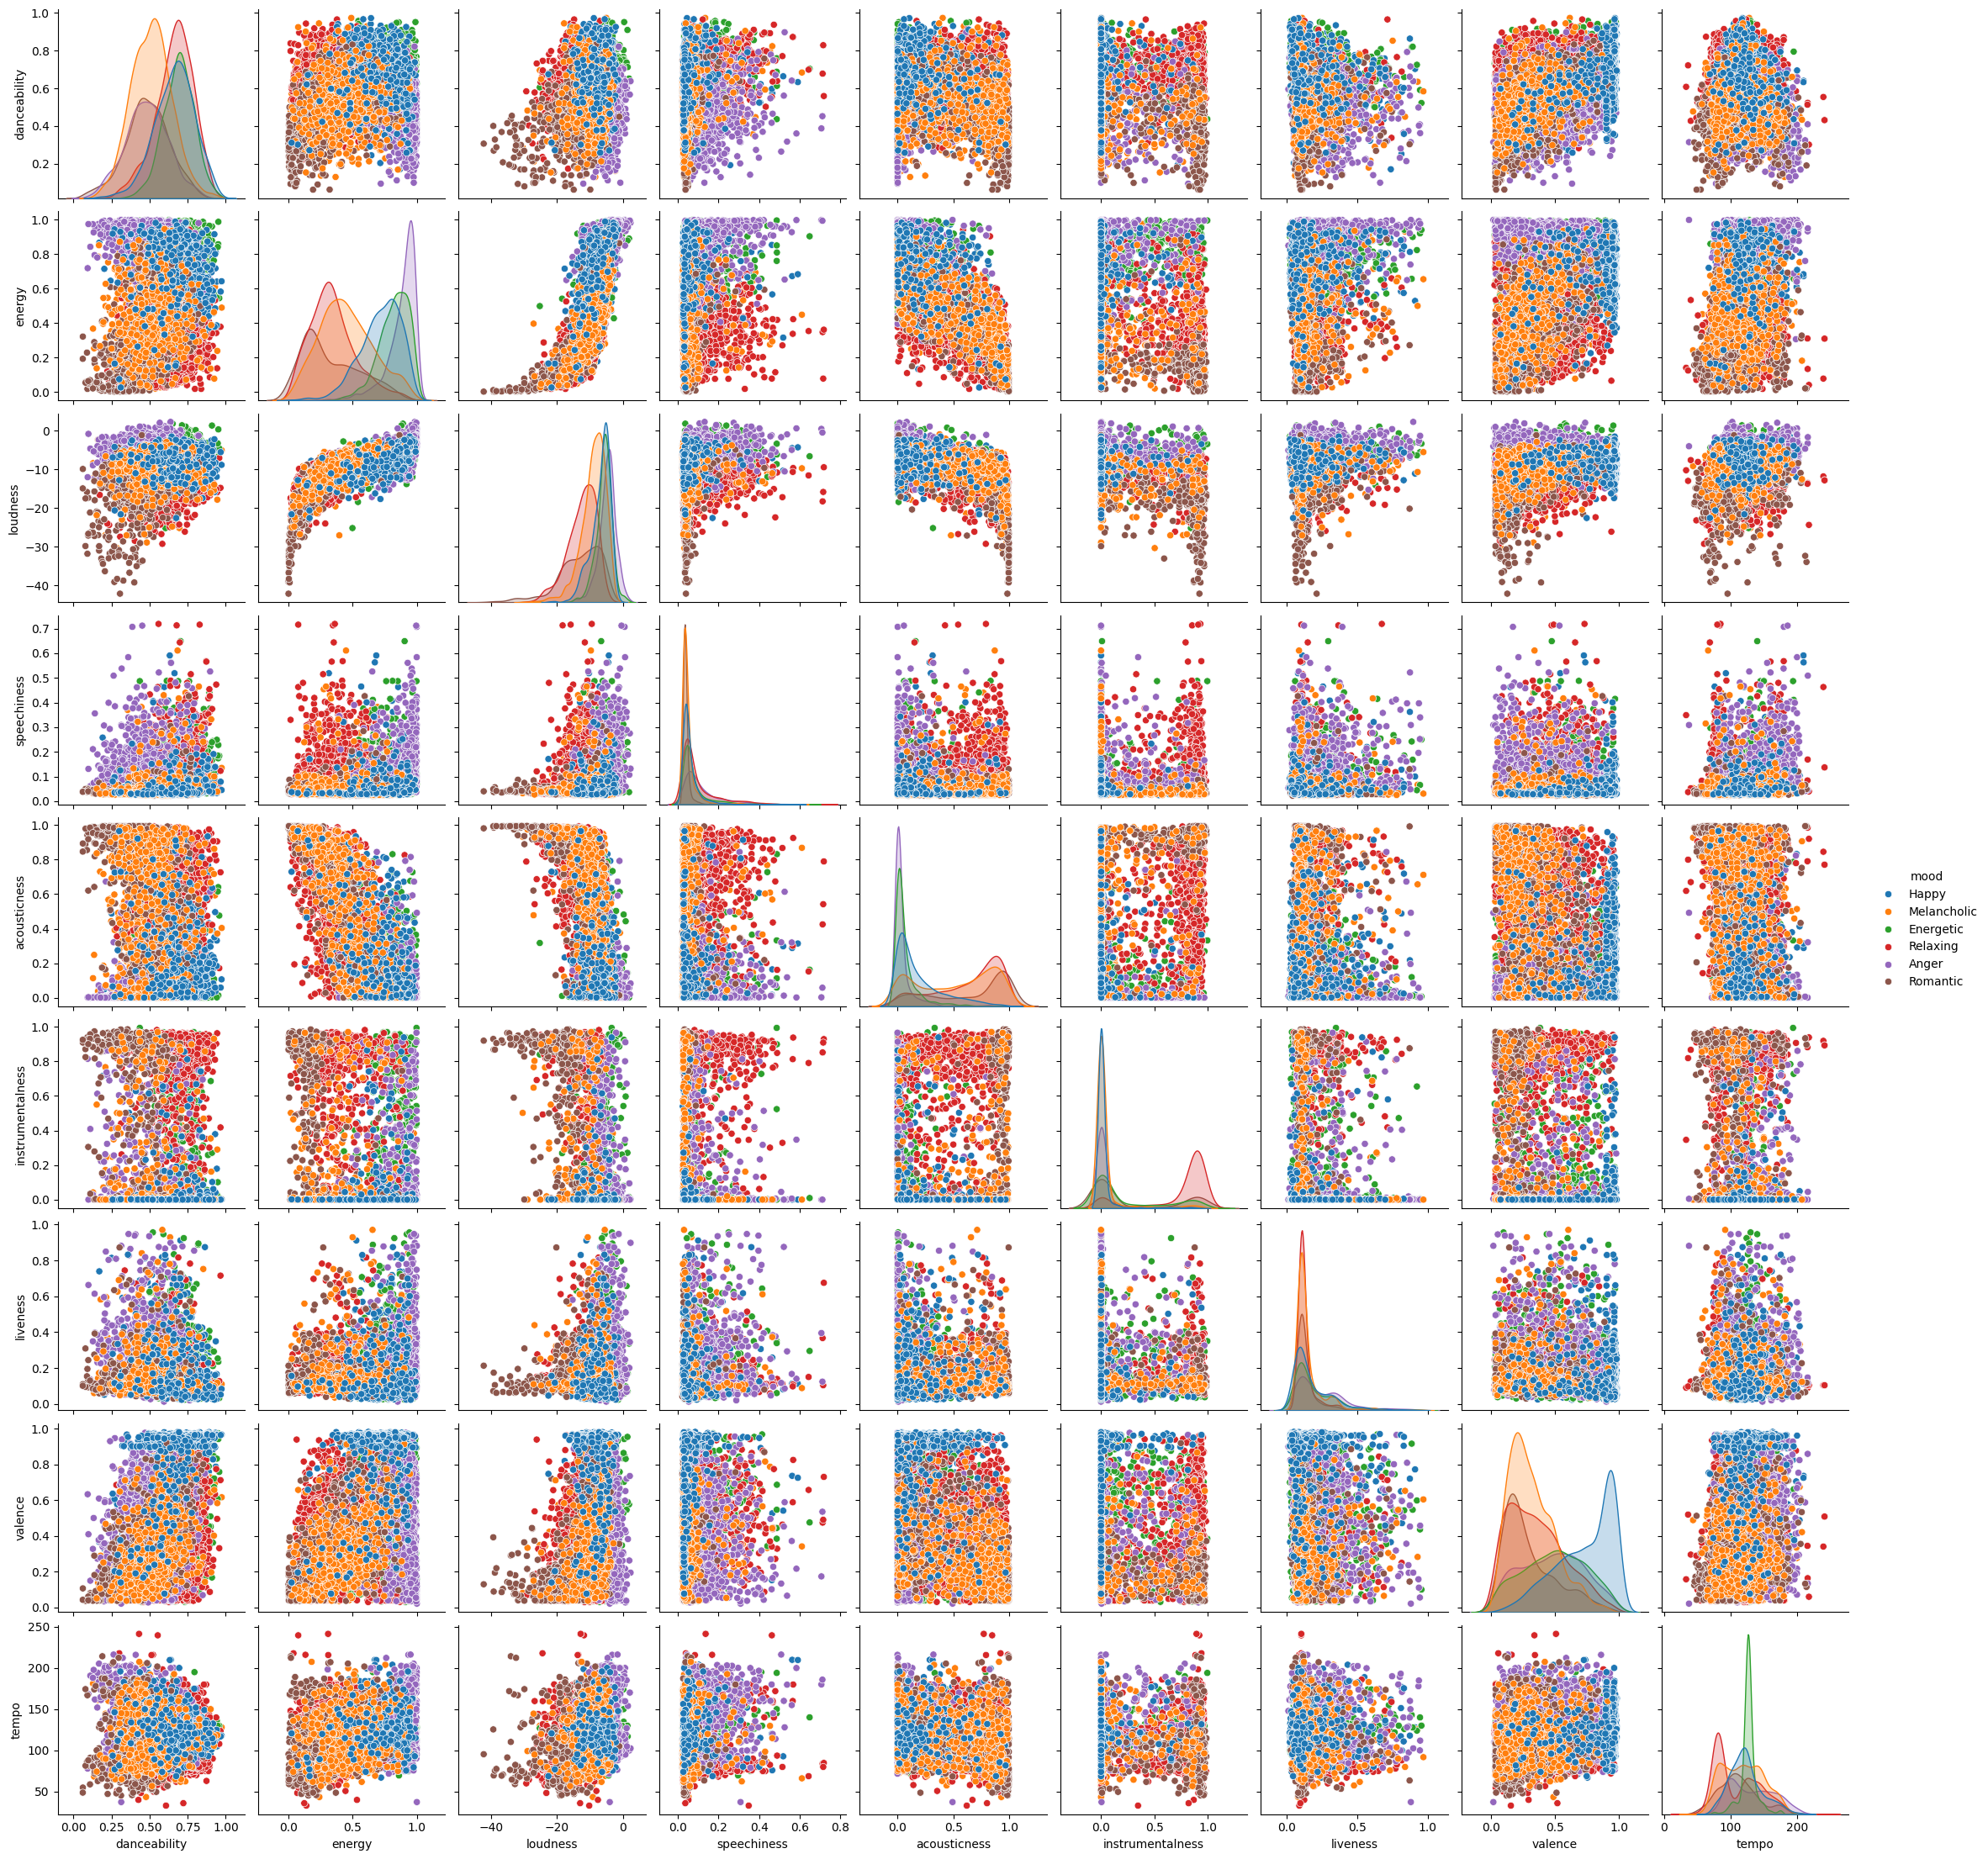

In [15]:
sns.pairplot(
    df,
    vars = df_num.columns,
    diag_kind = 'kde',
    hue = "mood"
)
plt.show()

Plot the Pearson's Correlation Coefficient for the numerical features.

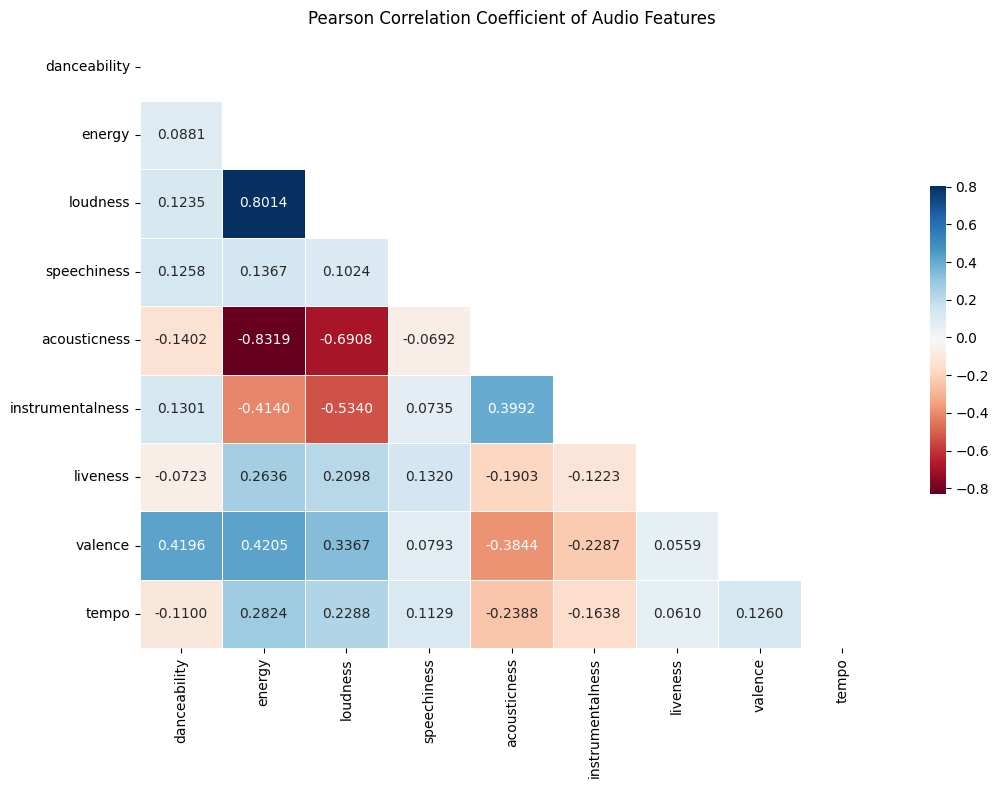

In [16]:
plt.figure(figsize=(12, 8))

corr = df_num.corr(method = 'pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    mask = mask,
    cmap = 'RdBu', 
    annot = True, 
    fmt = '.4f', 
    linewidths = .5,
    cbar_kws = {"shrink": .5}
)

plt.title('Pearson Correlation Coefficient of Audio Features')
plt.show()

Since `genres` are tied to each artist, it might be a good idea to ensure that there are no songs that share an artist between moods. 

In [17]:
artist_mood_df = df[['artist', 'mood']]
artist_mood_df.loc[:, 'artist'] = artist_mood_df['artist'].str.split(', ')
artist_mood_df = artist_mood_df.explode('artist')
artist_mood_df = artist_mood_df[['artist', 'mood']].drop_duplicates()
artist_mood_df = artist_mood_df.merge(artist_mood_df, on='artist')
artist_mood_df = artist_mood_df[artist_mood_df['mood_x'] != artist_mood_df['mood_y']]
artist_mood_df.loc[:, 'mood_pair'] = artist_mood_df.apply(lambda row: tuple(sorted([row['mood_x'], row['mood_y']])), axis=1)
shared_artists_count = artist_mood_df.groupby('mood_pair')['artist'].nunique().reset_index()

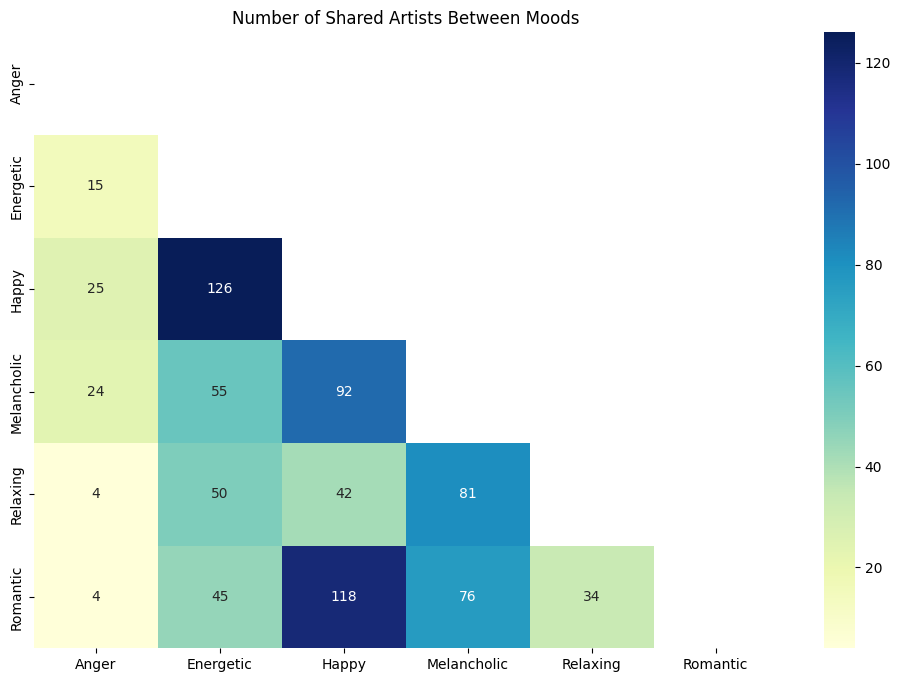

In [18]:
mood_pairs = shared_artists_count['mood_pair'].tolist()
moods = sorted(set([m for pair in mood_pairs for m in pair]))
heatmap_data = pd.DataFrame(0, index=moods, columns=moods)
for row in shared_artists_count.itertuples():
    mood1, mood2 = row.mood_pair
    heatmap_data.loc[mood1, mood2] = row.artist
    heatmap_data.loc[mood2, mood1] = row.artist

mask = np.triu(np.ones_like(heatmap_data, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    mask = mask,
    annot = True, 
    cmap = "YlGnBu", 
    cbar=True, 
    fmt = 'd'
)
plt.title('Number of Shared Artists Between Moods')
plt.show()

#### Bivariate Observations:

* Happy songs typically have higher valence.
* Relaxing songs typically have higher instrumentalness.
* Energetic songs have a narrower range of tempo.
* Moods can generally be grouped into two: Happy, Angry, and Energetic for high energy-low acousticness songs and Romantic, Relaxing, and Melancholic for low energy-high acousticness songs.
* High positive correlation between loudness and energy.
* High negative correlation between acousticness and energy, and acousticness and loudness.
* Shared artists between moods exist that might need to be isolated to just one mood.

## Step 2: Data Preparation

First, let's clean the data based on our observations in the initial EDA.

Remove duplicated rows.

In [19]:
df = df.drop_duplicates()
df.shape

(6649, 20)

Drop rows with null audio_features

In [20]:
df = df.dropna(subset = num_feat)
df.shape

(6646, 20)

Investigate further the remaining missing genres.

In [21]:
num_null_genres = df['genres'].isna().sum()
print(f'Null Genres: {num_null_genres}')

Null Genres: 1228


In [22]:
null_genres_df = df[df['genres'].isna()].groupby('mood').size().reset_index(name='null_genres_count')
print(null_genres_df)

          mood  null_genres_count
0        Anger                 63
1    Energetic                 81
2        Happy                 49
3  Melancholic                 87
4     Relaxing                739
5     Romantic                209


The `Relaxing` songs in our dataset are all from lo-fi playlists, so imputing for the null genres in that subset will be easy. 

For the rest of the songs with a null genre, we will group them by their moods then do mode imputing to fill them.

In [23]:
df.loc[(df['mood'] == 'Relaxing') & (df['genres'].isna()), 'genres'] = 'lo-fi'

In [24]:
mode_genres = df.dropna(subset=['genres']).groupby('mood')['genres'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'unknown')
for mood, mode_genre in mode_genres.items():
    df.loc[(df['mood'] == mood) & (df['genres'].isna()), 'genres'] = mode_genre

In [25]:
num_null_genres = df['genres'].isna().sum()
print(f'Null Genres: {num_null_genres}')

Null Genres: 0


In the `genres` analysis generated by ydata-profiling, we can see that we have over 800 unique words in the genres column.

In [26]:
def print_genre_counts(df):
    def count_unique_genres(df):
        all_genres = df['genres'].dropna().str.split(', ').sum()
        unique_genres = set(all_genres)
        genre_counts = pd.Series(all_genres).value_counts()
        return len(unique_genres), genre_counts

    num_unique_genres, genre_counts = count_unique_genres(df)
    print("Number of unique genres:", num_unique_genres)
    print('________________________________________')
    print(genre_counts)
print_genre_counts(df)

Number of unique genres: 1291
________________________________________
pop                1252
lo-fi               743
dance pop           404
rock                343
pop dance           312
                   ... 
nz electronic         1
cedm                  1
tekno                 1
trance mexicano       1
miami bass            1
Name: count, Length: 1291, dtype: int64


And here we can see that there's almost 1300 unique combinations of those words in the genre column. Let's simplify most of them to a more general genre.

In [27]:
keywords = ['acoustic', 'lo-fi', 'pop', 'rap', 'rock', 'hip hop', 'country', 'jazz', 'blues', 'indie', 'reggae', 'folk', 'classical', 
            'emo', 'metal', 'punk', 'grunge', 'alternative', 'indie', 'r&b', 'soul', 'funk', 'dance', 'disco', 'edm']

In [28]:
for i, row in df.iterrows():
    genres = row['genres']
    if isinstance(genres, str): 
        genres = genres.split(', ')
        cleaned_genres = []
        for genre in genres:
            matched_keywords = []
            for keyword in keywords:
                if keyword in genre:
                    matched_keywords.append(keyword)
            if matched_keywords:
                cleaned_genres.extend(matched_keywords)
            else:
                cleaned_genres.append(genre)
        cleaned_genres = list(set(cleaned_genres)) 
        df.at[i, 'genres'] = ', '.join(cleaned_genres)

In [29]:
print_genre_counts(df)

Number of unique genres: 521
________________________________________
pop                                2805
rock                               1194
lo-fi                              1088
indie                               851
dance                               725
jazz                                658
punk                                563
soul                                426
alternative                         384
rap                                 321
edm                                 318
folk                                220
r&b                                 186
funk                                184
disco                               178
permanent wave                      169
hip hop                             163
house                               161
grunge                              153
alt z                               152
neo mellow                          148
emo                                 146
mellow gold                         141
uptempo ha

For the remaining niche subgenres, we'll map it to one of the genres in the `keywords` list as best as we could. And drop the subgenres that are too niche to be mapped.

In [30]:
genre_mapping = {
    'trip hop': ['hip hop'],
    'small room': ['lo-fi'],
    'christian': ['pop'],
    'ccm': ['pop'],
    'stomp and holler': ['blues', 'folk'],
    'big beat': ['edm'],
    'riot grrrl': ['punk'],
    'pixie': ['pop', 'edm'],
    'screamo': ['emo'],
    'girl group': ['pop'],
    'tronic': ['edm'],
    'rave': ['edm'],
    'orchestra': ['classical'],
    'deathcore': ['metal'],
    'phonk': ['hip hop'],
    'lilith': ['folk'],
    'crank wave': ['edm'],
    'chillhop': ['lo-fi'],
    'mellow gold': ['rock', 'folk'],
    'grunge': ['alternative', 'rock'],
    'ska': ['reggae'],
    'brostep': ['edm'],
    'alt z': ['hip hop'],
    'neo mellow': ['rock'],
    'permanent wave': ['pop'],
    'new wave': ['pop'],
    'electr': ['edm'],
    'singer-songwriter': ['acoustic'],
    'hardcore': ['punk'],
    'boy band': ['pop'],
    'talent show': ['pop'],
    'motown': ['r&b'],
    'quiet storm': ['r&b'],
    'study beats': ['lo-fi'],
    'urban contemporary': ['hip hop', 'r&b', 'pop'],
    'trance': ['edm'],
    'house': ['edm'],
    'big room': ['edm'],
    'techno': ['edm'],
    'drill' : ['hip hop'],
    'romantic' : ['classical'],
    'baroque' : ['classical'],
    'melancholia' : ['emo'],
    'adult standards' : ['jazz'],
    'moombahton' : ['edm'],
    'hardstyle' : ['edm'],
    'frenchcore' : ['edm'],
    'madchester' : ['edm'],
    'shoegaze' : ['alternative', 'rock'],
    'tekk' : ['edm'],
    'bounce' : ['edm'],
    'thrash' : ['metal'],
    'complextro' : ['edm'],
    'orgcore' : ['punk'],
    'downtempo' : ['edm'],
    'uk82' : ['punk'],
    'rawstyle' : ['edm'],
    'focus beats' : ['lo-fi'],
    'escape room' : ['pop'],
    'soundtrack' : ['pop'],
    'lounge' : ['lo-fi'],
    'ambeat' : ['edm', 'lo-fi'],
    'violin' : ['classical'],
    'vapor' : ['edm'],
    'afrobeat' : ['jazz', 'soul', 'funk'],
    'future bass' : ['edm'],
    'early music' : ['classical'],
    'chill' : ['lo-fi']
}

In [31]:
def map_genres(genres_str, genre_mapping):
    if pd.isna(genres_str):
        return ''
    genres = genres_str.split(', ')
    mapped_genres = set()
    for genre in genres:
        matched = False
        for keyword, general_genres in genre_mapping.items():
            if keyword in genre:
                mapped_genres.update(general_genres)
                matched = True
                break
        if not matched:
            mapped_genres.add(genre)
    return ', '.join(sorted(mapped_genres))

df['genres'] = df['genres'].apply(lambda x: map_genres(x, genre_mapping))

print_genre_counts(df)

Number of unique genres: 248
________________________________________
pop                                2993
rock                               1313
lo-fi                              1206
edm                                 872
indie                               851
dance                               725
punk                                722
jazz                                705
hip hop                             594
alternative                         465
soul                                434
r&b                                 362
folk                                346
rap                                 321
acoustic                            275
emo                                 207
funk                                192
disco                               178
classical                           149
metal                               135
blues                                99
country                              92
reggae                               62
british in

In [32]:
def filter_genres(genre_str):
    genres = [genre.strip() for genre in genre_str.split(',') if genre.strip() in keywords]
    return ', '.join(genres)

df['genres'] = df['genres'].apply(filter_genres)

print_genre_counts(df)

Number of unique genres: 24
________________________________________
pop            2993
rock           1313
lo-fi          1206
edm             872
indie           851
dance           725
punk            722
jazz            705
hip hop         594
alternative     465
soul            434
r&b             362
folk            346
rap             321
acoustic        275
emo             207
funk            192
disco           178
classical       149
metal           135
blues            99
country          92
                 63
reggae           62
Name: count, dtype: int64


In [33]:
print(df.shape)

(6646, 20)


And finally, drop the rows that will be left with a null genre.

In [34]:
df = df[df['genres'] != '']
print(df.shape)

(6583, 20)


#### One-hot encode genres.

In [35]:
df_onehot_genre = pd.get_dummies(df['genres'].str.get_dummies(', '))
df_onehot_genre.columns = ['genre_' + col.lower() for col in df_onehot_genre.columns]
df = pd.concat([df, df_onehot_genre], axis = 1)
df = df.drop(columns = ['genres'], axis = 1)
print(df.columns)

Index(['title', 'artist', 'year', 'album', 'popularity', 'mood',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'genre_acoustic', 'genre_alternative',
       'genre_blues', 'genre_classical', 'genre_country', 'genre_dance',
       'genre_disco', 'genre_edm', 'genre_emo', 'genre_folk', 'genre_funk',
       'genre_hip hop', 'genre_indie', 'genre_jazz', 'genre_lo-fi',
       'genre_metal', 'genre_pop', 'genre_punk', 'genre_r&b', 'genre_rap',
       'genre_reggae', 'genre_rock', 'genre_soul'],
      dtype='object')


Remove tracks that share an artist from other moods.

In [37]:
# mood_order = ['Anger', 'Energetic', 'Melancholic', 'Happy', 'Romantic', 'Relaxing']

mood_order = ['Anger', 'Happy', 'Energetic', 'Melancholic', 'Romantic', 'Relaxing']

for mood in mood_order:
        mood_df = df[df['mood'] == mood]
        mood_artists = set()
        mood_df['artist'].str.split(', ').apply(mood_artists.update)
        df = df[~((df['mood'] != mood) & (df['artist'].str.split(', ').apply(lambda artists: any(artist in mood_artists for artist in artists))))]

print(df.shape)

(5344, 42)


Now we can drop the remaining unnecessary columns. We're also dropping popularity because unlike the other audio features, it is not static. It is frequently changed by Spotify based on the number of streams each song got in the past timeframe, which makes it favor newly released songs.

In [38]:
df = df.drop(columns = ['title', 'artist', 'year', 'album', 'popularity'], axis = 1)

#### Encode mood using frequency encoding.

In [39]:
frequency = df['mood'].value_counts(normalize = True)
df['mood_freq'] = df['mood'].map(frequency)

In [40]:
df.head()

mood  danceability  energy   key  loudness  mode  speechiness  \
0  Happy         0.775   0.573  11.0    -4.933   1.0       0.0585   
1  Happy         0.794   0.766   9.0    -3.894   0.0       0.0377   
2  Happy         0.640   0.673   5.0    -4.519   0.0       0.5630   
4  Happy         0.620   0.761  10.0    -7.282   0.0       0.1750   
5  Happy         0.722   0.709   9.0    -4.950   1.0       0.0273   

   acousticness  instrumentalness  liveness  valence    tempo  duration_ms  \
0        0.4950          0.000000    0.1260    0.667  101.925     171806.0   
1        0.0135          0.000000    0.0785    0.550  127.006     195873.0   
2        0.2880          0.000002    0.1130    0.736  209.942     195147.0   
4        0.2070          0.000147    0.2690    0.194  146.003     209483.0   
5        0.0633          0.000000    0.0804    0.604   81.012     171292.0   

   time_signature  genre_acoustic  genre_alternative  genre_blues  \
0             4.0               0                  0            0   
1             4.0               0                  0            0   
2             4.0               0                  1            0   
4             4.0               0                  0            0   
5             4.0               0                  0            0   

   genre_classical  genre_country  genre_dance  genre_disco  genre_edm  \
0                0              0            1            0          1   
1                0              0            1            0          0   
2                0              0            0            0          0   
4                0              0            0            0          0   
5                0              0            0            0          0   

   genre_emo  genre_folk  genre_funk  genre_hip hop  genre_indie  genre_jazz  \
0          0           0           1              0            0           0   
1          0           0           0              1            1           0   
2          0           0           0              1            0           0   
4          0           0           0              0            1           0   
5          0           0           0              0            0           0   

   genre_lo-fi  genre_metal  genre_pop  genre_punk  genre_r&b  genre_rap  \
0            0            0          1           0          1          1   
1            0            0          1           0          0          1   
2            0            0          0           0          1          1   
4            0            0          0           0          1          0   
5            0            0          1           0          0          1   

   genre_reggae  genre_rock  genre_soul  mood_freq  
0             0           0           0   0.205277  
1             0           1           0   0.205277  
2             0           0           0   0.205277  
4             0           0           1   0.205277  
5             0           0           0   0.205277

Final check on null values.

In [36]:
null_counts = df.isna().sum()
print(null_counts)

title                0
artist               0
year                 0
album                0
popularity           0
mood                 0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
genre_acoustic       0
genre_alternative    0
genre_blues          0
genre_classical      0
genre_country        0
genre_dance          0
genre_disco          0
genre_edm            0
genre_emo            0
genre_folk           0
genre_funk           0
genre_hip hop        0
genre_indie          0
genre_jazz           0
genre_lo-fi          0
genre_metal          0
genre_pop            0
genre_punk           0
genre_r&b            0
genre_rap            0
genre_reggae         0
genre_rock           0
genre_soul           0
dtype: int64


## Step 3: Model Training and Testing

Let's determine and choose the best performing model(s).

In [41]:
X_freq = df.drop(columns=['mood', 'mood_freq'])
y_freq = df['mood']

In [42]:
print(f'X_freq Columns: {X_freq.columns}')
print(f'y_freq Shape: {y_freq.shape}')

X_freq Columns: Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'genre_acoustic', 'genre_alternative',
       'genre_blues', 'genre_classical', 'genre_country', 'genre_dance',
       'genre_disco', 'genre_edm', 'genre_emo', 'genre_folk', 'genre_funk',
       'genre_hip hop', 'genre_indie', 'genre_jazz', 'genre_lo-fi',
       'genre_metal', 'genre_pop', 'genre_punk', 'genre_r&b', 'genre_rap',
       'genre_reggae', 'genre_rock', 'genre_soul'],
      dtype='object')
y_freq Shape: (5344,)


In [43]:
y_freq.value_counts()

mood
Relaxing       1208
Happy          1097
Anger           907
Melancholic     808
Energetic       680
Romantic        644
Name: count, dtype: int64

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_freq, y_freq, test_size = 0.20, random_state = 13)
print(f'Class distribution: {pd.Series(y_train).value_counts()}')

Class distribution: mood
Relaxing       962
Happy          888
Anger          726
Melancholic    636
Energetic      549
Romantic       514
Name: count, dtype: int64


Oversample every class except for the majority class on the **training set** using SMOTE to make our dataset balanced.

In [45]:
smote = SMOTE(sampling_strategy = 'not majority')

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f'New class distribution: {pd.Series(y_train_smote).value_counts()}')

New class distribution: mood
Happy          962
Melancholic    962
Romantic       962
Energetic      962
Anger          962
Relaxing       962
Name: count, dtype: int64


Then normalize the training set and testing set **separately** to avoid leakage.

In [46]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

Let's quickly train and fit multiple models that are capable of multiclass classification and choose the top performing ones. No cross-validation and optimized hyperparameters for now to make this process quickly.

In [47]:
predictions = {}
accuracies = {}
confusion_matrices = {}
classification_reports = {}

In [50]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_smote)
y_test_encoded = label_encoder.transform(y_test)

In [51]:
models = [
    ('AdaBoost', AdaBoostClassifier(random_state = 13, algorithm = 'SAMME')),
    ('Decision Tree', DecisionTreeClassifier(random_state = 13)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state = 13)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Linear Discriminant Analysis', LinearDiscriminantAnalysis()),
    ('Logistic Regression', LogisticRegression(max_iter = 1000, random_state = 13)),
    ('Random Forest', RandomForestClassifier(random_state = 13)),
    ('Support Vector Machine', SVC(random_state = 13, decision_function_shape = 'ovr')),
    ('XGBoost', xgb.XGBClassifier(objective='multi:softmax', random_state=13)),
]

In [52]:
for name, model in models:
    model.fit(X_train_scaled, y_train_encoded)
    predictions[name] = model.predict(X_test_scaled)
    accuracies[name] = accuracy_score(y_test_encoded, predictions[name])
    confusion_matrices[name] = confusion_matrix(y_test_encoded, predictions[name])
    classification_reports[name] = classification_report(y_test_encoded, predictions[name], output_dict = True)
    print(f'{name} Accuracy: {accuracies[name]}')

AdaBoost Accuracy: 0.7904583723105706
Decision Tree Accuracy: 0.7867165575304023
Gradient Boosting Accuracy: 0.8774555659494855
K-Nearest Neighbors Accuracy: 0.8681010289990645
Linear Discriminant Analysis Accuracy: 0.852198316183349
Logistic Regression Accuracy: 0.8671655753040225
Random Forest Accuracy: 0.892422825070159
Support Vector Machine Accuracy: 0.8849391955098223
XGBoost Accuracy: 0.8840037418147801


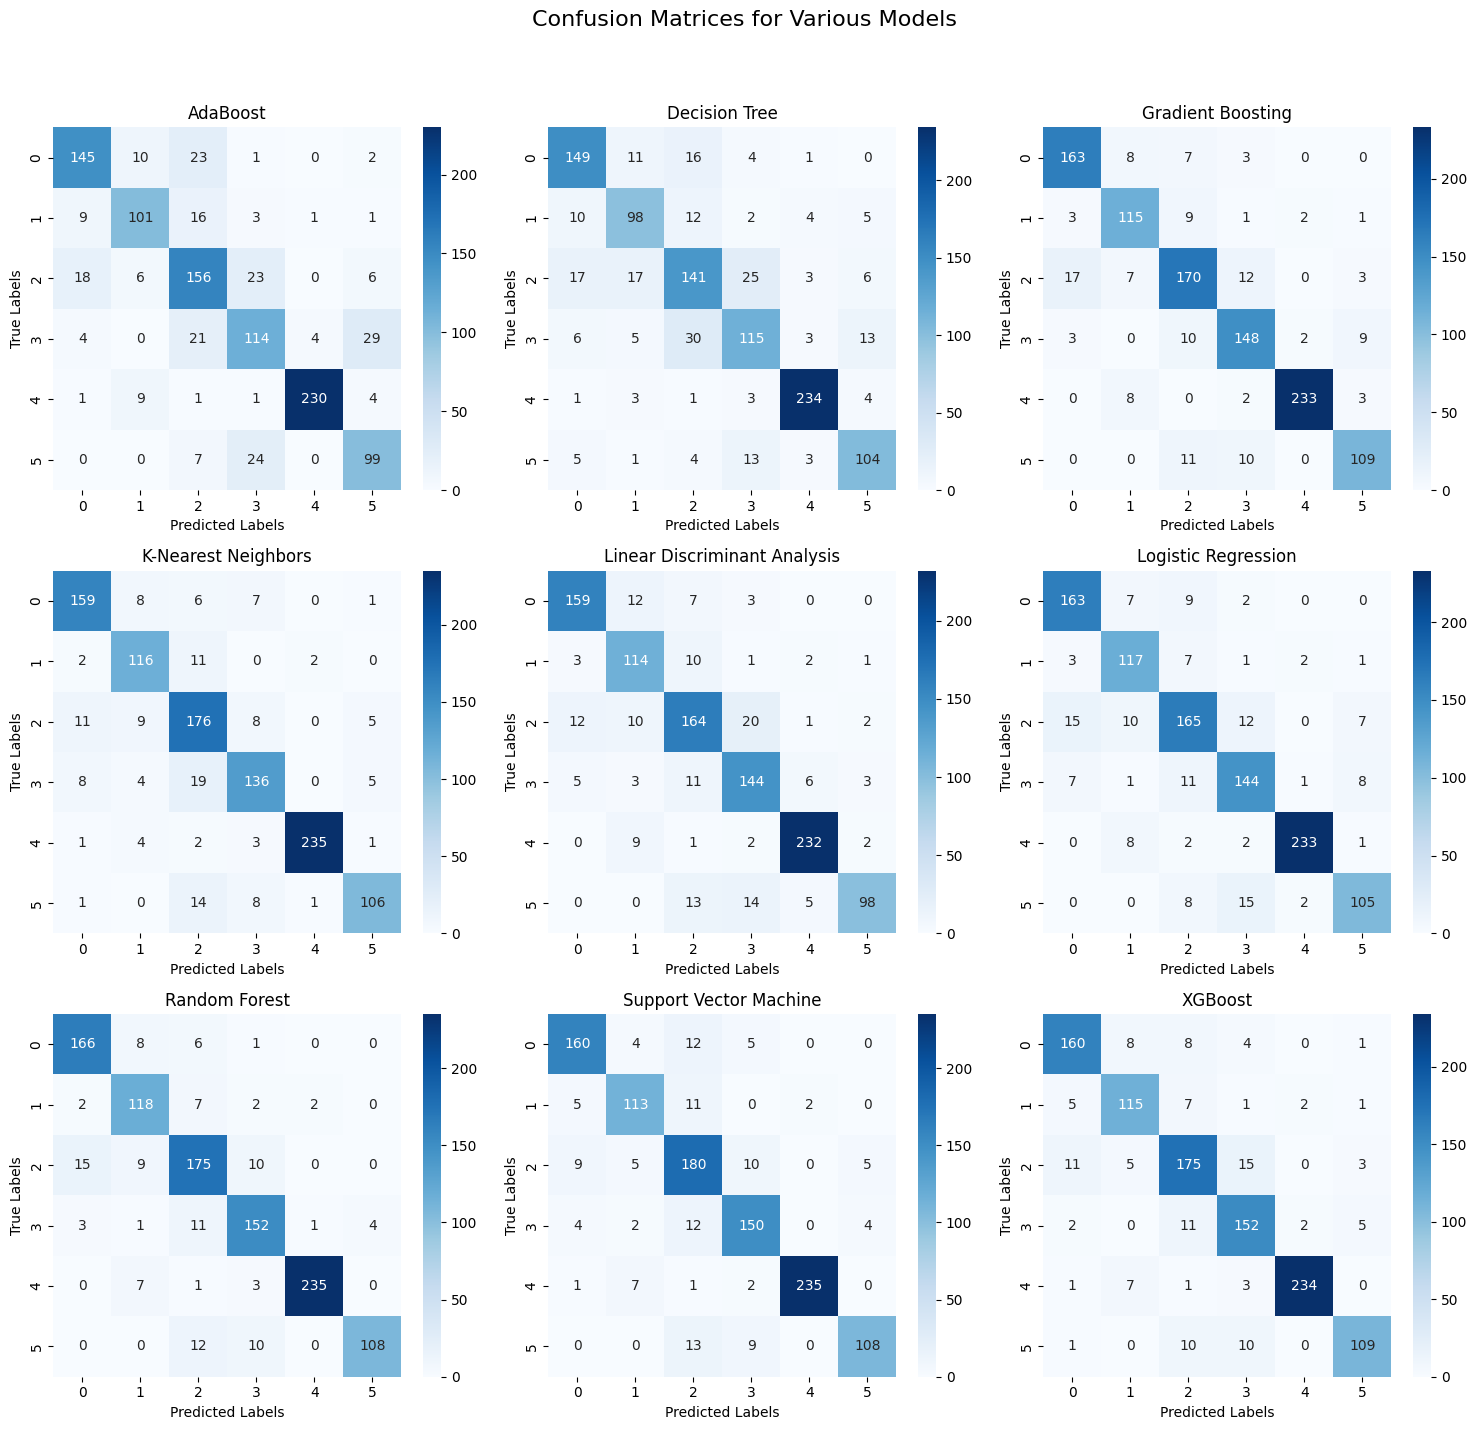

In [53]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 15))
fig.suptitle('Confusion Matrices for Various Models', fontsize = 16)

for ax, (name, matrix) in zip(axes.flatten(), confusion_matrices.items()):
    sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Blues', ax = ax)
    ax.set_title(name)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

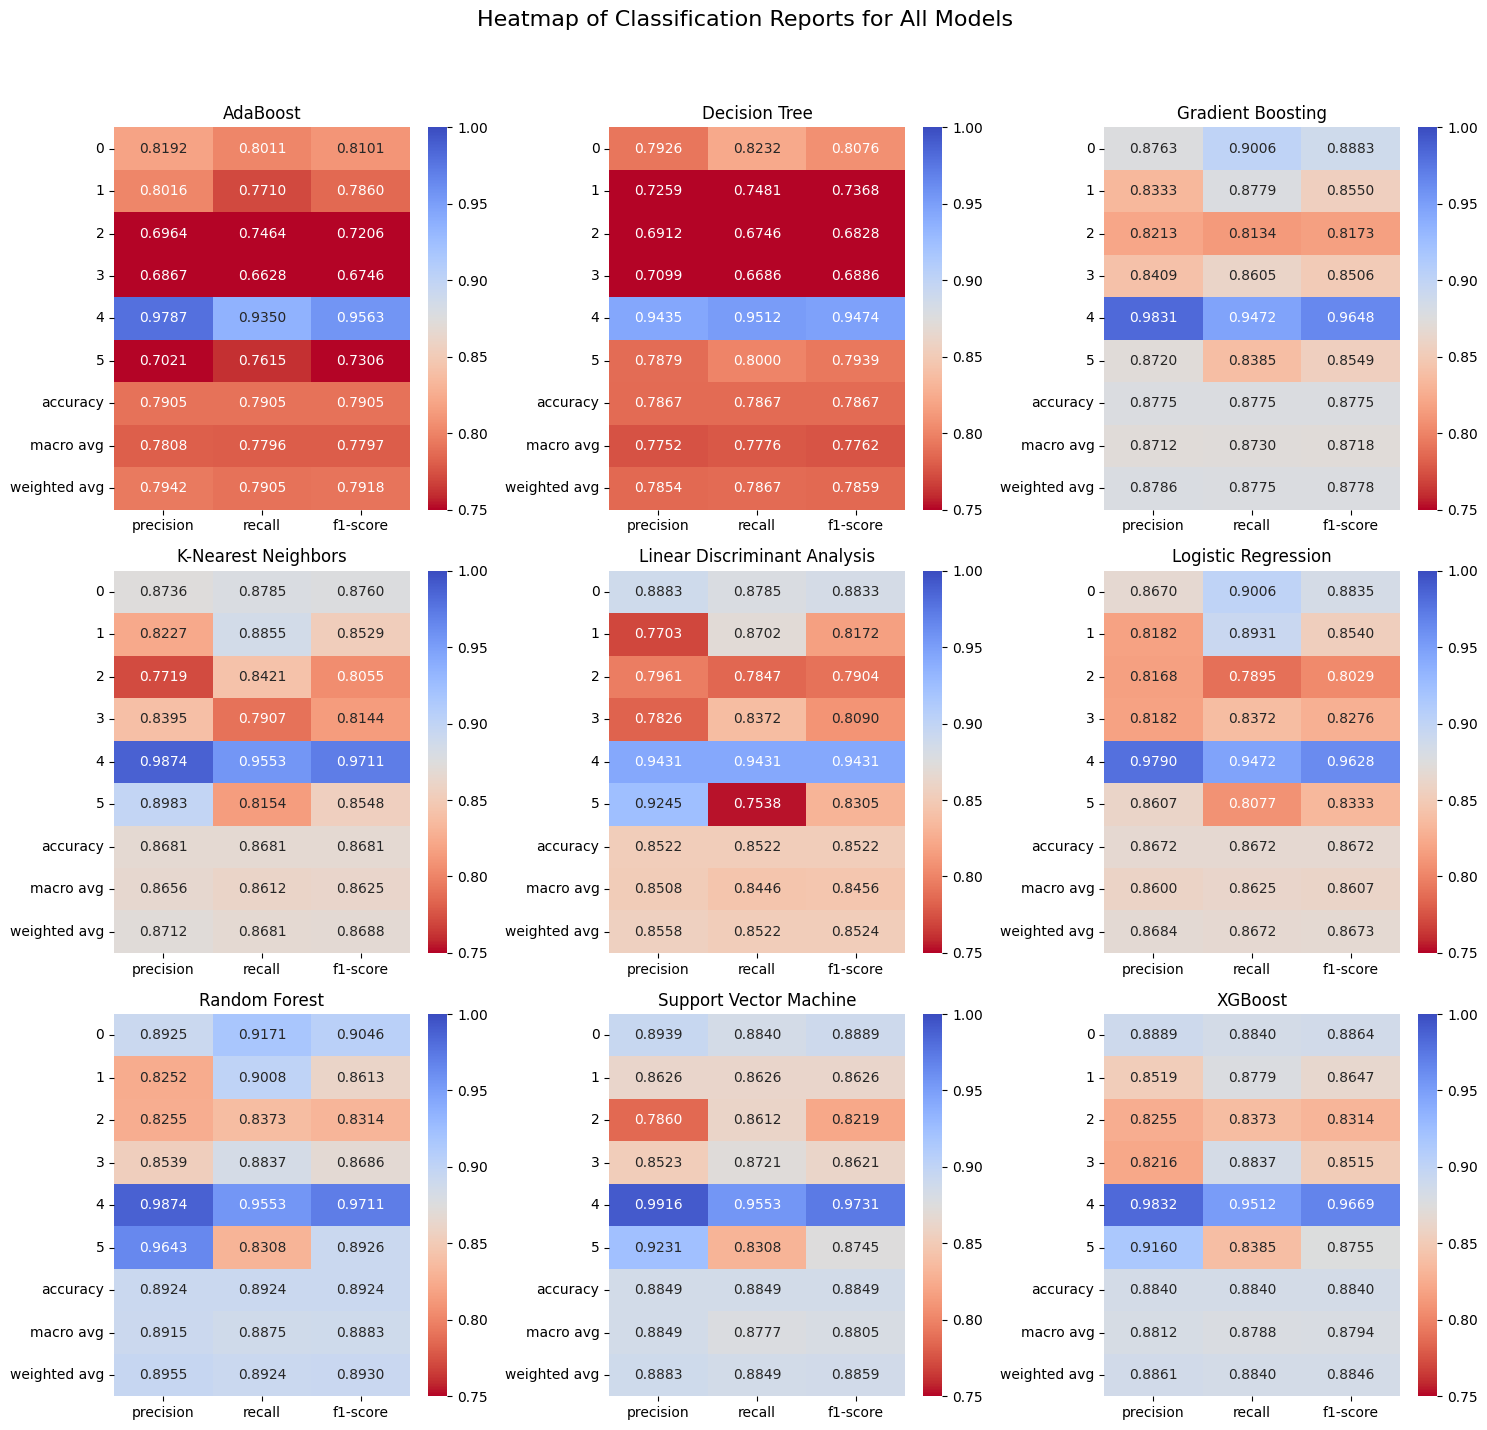

In [70]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 15))  
fig.suptitle('Heatmap of Classification Reports for All Models', fontsize = 16)

for ax, (name, report) in zip(axes.flatten(), classification_reports.items()):
    report_df = pd.DataFrame(report).iloc[:-1, :].T
    sns.heatmap(report_df, annot = True, fmt = ".4f", cmap = 'coolwarm_r', ax = ax, vmin = 0.75, vmax = 1.0)
    ax.set_title(f'{name}')

plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

The three best performing models are Random Forest, Support Vector Machine, and XGBoost. So we'll try to optimize its hyperparameters using random search to see if it can be further improved without being too computationally expensive. We'll use a five-fold cross validation to ensure a more robust model.

### Random Forest Algorithm

In [55]:
param_distributions_rf = {
    'n_estimators': np.arange(50, 221, 10),
    'max_features': np.arange(10, 25, 2),
    'max_depth': np.arange(12, 28, 3)
}

rf = RandomForestClassifier(random_state = 13)

random_search_rf = RandomizedSearchCV(
    estimator = rf,
    param_distributions = param_distributions_rf,
    n_iter = 100,  
    cv = 5,       
    verbose = 3,
    scoring = 'accuracy', 
    random_state = 13,
    n_jobs = -1    
)

random_search_rf.fit(X_train_scaled, y_train_smote)
print(f'Best cross-validation score: {random_search_rf.best_score_}')
print(f'Best estimators found: {random_search_rf.best_estimator_}')
print(f'Best parameters found: {random_search_rf.best_params_}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best cross-validation score: 0.878729358452062
Best estimators found: RandomForestClassifier(max_depth=21, max_features=10, n_estimators=210,
                       random_state=13)
Best parameters found: {'n_estimators': 210, 'max_features': 10, 'max_depth': 21}


In [56]:
best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf) 
print(f'Random Forest Model Accuracy: {accuracy_rf}')

Random Forest Model Accuracy: 0.8896164639850327


In [57]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

       Anger       0.89      0.91      0.90       181
   Energetic       0.83      0.89      0.86       131
       Happy       0.82      0.85      0.83       209
 Melancholic       0.86      0.86      0.86       172
    Relaxing       0.99      0.96      0.97       246
    Romantic       0.94      0.83      0.88       130

    accuracy                           0.89      1069
   macro avg       0.89      0.88      0.88      1069
weighted avg       0.89      0.89      0.89      1069



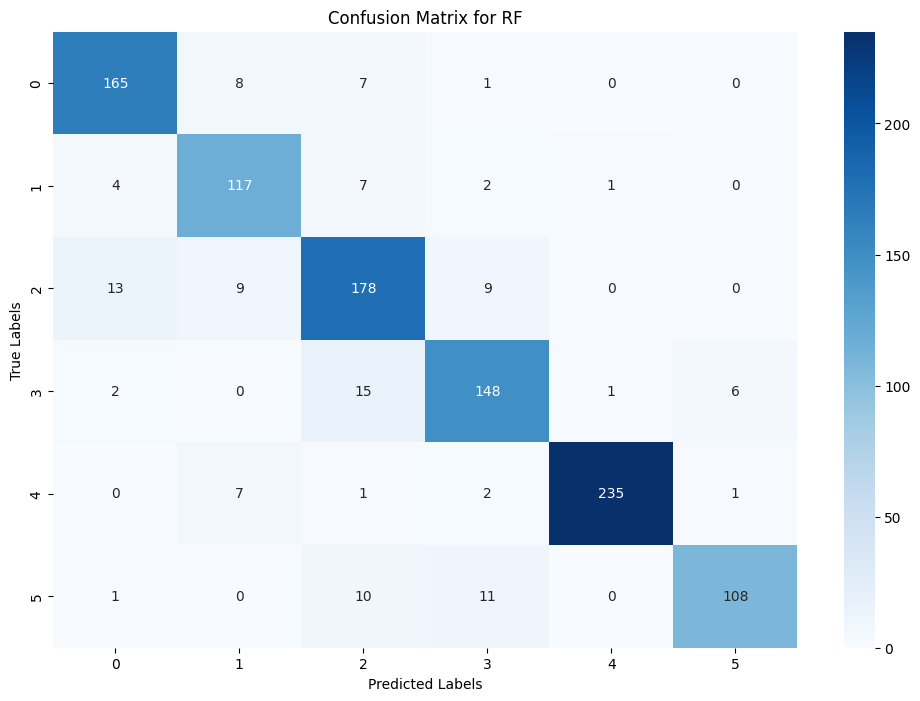

In [58]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(12, 8))
sns.heatmap(
    conf_matrix,
    annot=True, 
    fmt='d', 
    cmap='Blues'
)
plt.title('Confusion Matrix for RF')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Check feature importance

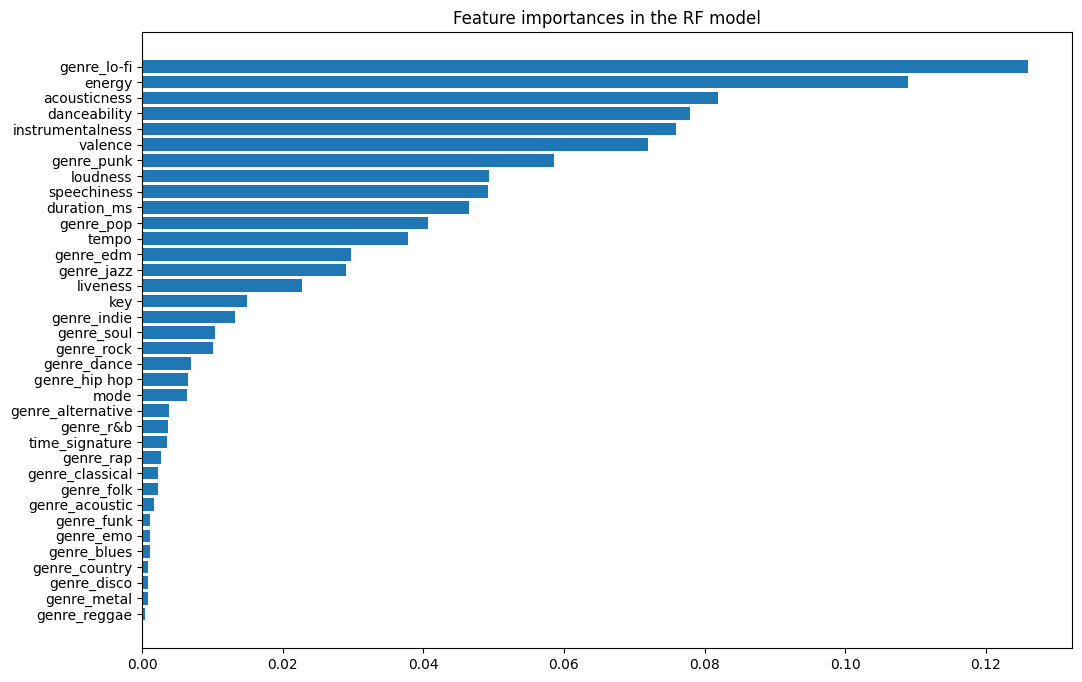

In [59]:
feature_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'genre_acoustic', 'genre_alternative',
       'genre_blues', 'genre_classical', 'genre_country', 'genre_dance',
       'genre_disco', 'genre_edm', 'genre_emo', 'genre_folk', 'genre_funk',
       'genre_hip hop', 'genre_indie', 'genre_jazz', 'genre_lo-fi',
       'genre_metal', 'genre_pop', 'genre_punk', 'genre_r&b', 'genre_rap',
       'genre_reggae', 'genre_rock', 'genre_soul']

importances = best_rf.feature_importances_  
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature importances in the RF model")
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.gca().invert_yaxis() 
plt.show()

### Support Vector Machine

In [60]:
param_distributions_svm = {
    'C': np.logspace(-4, 4, 20),
    'gamma': np.logspace(-4, 4, 20)
}

svm = SVC(random_state = 13,
          kernel = 'rbf',
          decision_function_shape = 'ovr')

random_search_svm = RandomizedSearchCV(
    estimator = svm, 
    param_distributions = param_distributions_svm, 
    n_iter = 100, 
    scoring = 'accuracy', 
    n_jobs = -1, 
    cv = 5, 
    random_state = 13, 
    verbose = 3
)

random_search_svm.fit(X_train_scaled, y_train_smote)
print(f'Best cross-validation score: {random_search_svm.best_score_}')
print(f'Best estimators found: {random_search_svm.best_estimator_}')
print(f'Best parameters found: {random_search_svm.best_params_}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best cross-validation score: 0.8605353860466511
Best estimators found: SVC(C=10000.0, gamma=0.00026366508987303583, random_state=13)
Best parameters found: {'gamma': 0.00026366508987303583, 'C': 10000.0}


In [61]:
best_svm = random_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Model Accuracy: {accuracy_svm}')

SVM Model Accuracy: 0.8840037418147801


In [62]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

       Anger       0.86      0.88      0.87       181
   Energetic       0.84      0.90      0.87       131
       Happy       0.82      0.83      0.82       209
 Melancholic       0.86      0.87      0.86       172
    Relaxing       0.99      0.96      0.97       246
    Romantic       0.92      0.84      0.88       130

    accuracy                           0.88      1069
   macro avg       0.88      0.88      0.88      1069
weighted avg       0.89      0.88      0.88      1069



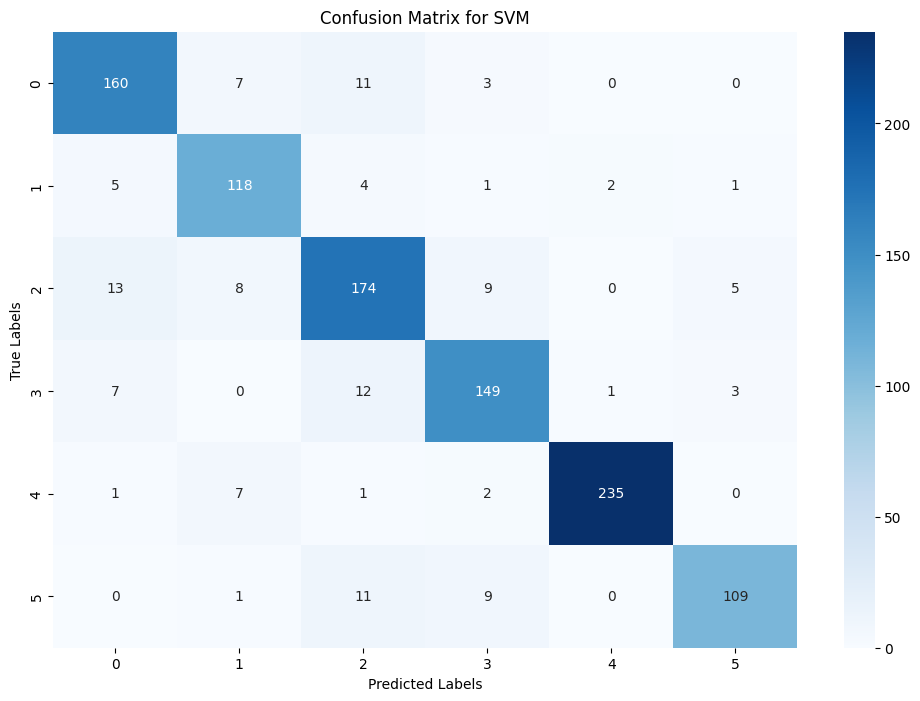

In [63]:
conf_matrix = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(12, 8))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues'
)
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### XGBoost

In [64]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_smote)
y_test_encoded = label_encoder.transform(y_test)

In [65]:
param_distributions_xgb = {
    'n_estimators': np.arange(50, 221, 10),
    'max_depth': np.arange(3, 25, 3),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'colsample_bytree': np.linspace(0.3, 1, 4)
}

In [66]:
xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax', 
    num_class=len(np.unique(y_train_encoded)), 
    random_state=13
)

random_search_xgb = RandomizedSearchCV(
   estimator = xgb_clf,
   param_distributions = param_distributions_xgb,
   n_iter = 100,
   scoring = 'accuracy',
   cv = 5, 
   verbose = 3,
   random_state = 13,
   n_jobs = -1  
)

random_search_xgb.fit(X_train_scaled, y_train_encoded)
print(f'Best cross-validation score: {random_search_xgb.best_score_}')
print(f'Best estimators found: {random_search_xgb.best_estimator_}')
print(f'Best parameters found: {random_search_xgb.best_params_}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best cross-validation score: 0.8920712447575532
Best estimators found: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5333333333333333, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07333333333333333,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=190, n_jobs=None, num_class=6,
              num_parallel_tree=None, ...)
Best parameters found: {'n_estimators': 190, 'max_depth': 9, 'learning_rate

In [67]:
best_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print(f'XGBoost Model Accuracy: {accuracy_xgb}')

XGBoost Model Accuracy: 0.8961646398503275


In [68]:
print(classification_report(y_test_encoded, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       181
           1       0.85      0.91      0.88       131
           2       0.84      0.85      0.85       209
           3       0.86      0.88      0.87       172
           4       0.99      0.96      0.97       246
           5       0.93      0.83      0.88       130

    accuracy                           0.90      1069
   macro avg       0.89      0.89      0.89      1069
weighted avg       0.90      0.90      0.90      1069



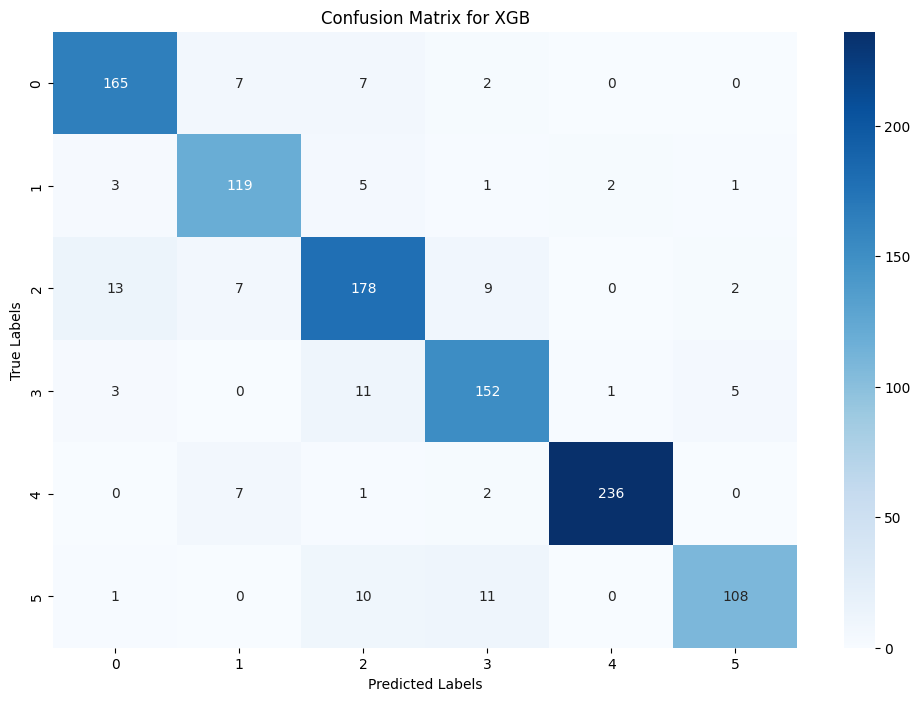

In [69]:
conf_matrix = confusion_matrix(y_test_encoded, y_pred_xgb)

plt.figure(figsize=(12, 8))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues'
)
plt.title('Confusion Matrix for XGB')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()